**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from types import SimpleNamespace
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate



## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
# Preliminary: parameters are defined

par = SimpleNamespace()
# firms
par.A = 1.0
par.gamma = 0.5
# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
# government
par.tau = 0.0
par.kappa = 0.1

In [3]:
#a) Let's define the functions for the firms:

#optimal labor
def l_star(par, w, p_j):
    '''Optimal labor l_j^*'''
    return ((p_j * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))

#optimal output
def optimal_y(par, w, p_j):
    '''Optimal output y_j^*'''
    l_j_star = l_star(par, w, p_j)
    return par.A * (l_j_star ** par.gamma)

#implied profits
def implied_profits(par, w, p_j):
    '''Implied profits pi_j^*'''
    return ((1 - par.gamma) / par.gamma) * w * ((p_j * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))

#b) Let's define the consumer functions:

#consumption of good 1
def c1(par, l, w, p1, p2,tau):
    ''' Consumption c1 '''
    profit_1 = implied_profits(par, w, p1)
    profit_2 = implied_profits(par, w, p2)
    y2 = optimal_y(par, w, p2)
    return par.alpha * (w * l + (tau*y2) + profit_1 + profit_2) / p1

#consumption of good 2
def c2(par, l, w, p1, p2,tau):  
    ''' Consumption c2 '''
    profit_1 = implied_profits(par, w, p1)
    profit_2 = implied_profits(par, w, p2)
    y2 = optimal_y(par, w, p2)
    return (1 - par.alpha) * (w * l + (tau*y2) + profit_1 + profit_2) / (p2 + tau)

#distutility of labor
def disutility(par, l):
    '''Disutility of labor'''
    return par.nu * l ** (1 + par.epsilon) / (1 + par.epsilon)

In [4]:
#c) Optimal total labour supply is computed:
def optimal_l_star(par, w, p1, p2,tau):

    # Objective function that incorporates the optimal consumption functions
    def objective(l, par, w, p1, p2,tau):
        c1_val = c1(par, l, w, p1, p2,tau)
        c2_val = c2(par, l, w, p1, p2,tau)
        return -(np.log(c1_val ** par.alpha * c2_val ** (1 - par.alpha)) - disutility(par, l))
    result = optimize.minimize(objective, args=(par, w, p1, p2,tau), x0=1.0)
    return result.x[0]

First, market clearing conditions are checked for each pairs of the arrays p1 and p2. 

In [5]:
# Grids for p1 and p2 are created:
p1 = np.linspace(0.1, 2.0, 10)
p2= np.linspace(0.1, 2.0, 10)

# The wage rate is defined as numeraire:
w = 1.0 

In [6]:
# Check market clearing conditions
market_clearing_results = []
tau = 0
for p1_values in p1:
    for p2_values in p2:
        ell_star = optimal_l_star(par, w, p1_values, p2_values,tau)
        c1_star = c1(par, ell_star, w, p1_values, p2_values,tau)
        c2_star = c2(par, ell_star, w, p1_values, p2_values,tau)
        y1_star = optimal_y(par, p1_values, w)
        y2_star = optimal_y(par, p2_values, w)
        lj1_star = l_star(par, p1_values, w)
        lj2_star = l_star(par, p2_values, w)
        
        labor_market_clearing = np.isclose(ell_star, lj1_star + lj2_star)
        good1_market_clearing = np.isclose(c1_star, y1_star)
        good2_market_clearing = np.isclose(c2_star, y2_star)

        market_clearing_results.append({
            "p1": p1_values,
            "p2": p2_values,
            "labor_market_clearing": labor_market_clearing,
            "good1_market_clearing": good1_market_clearing,
            "good2_market_clearing": good2_market_clearing
        })

As displayed above, for each combination of p1 and p2 from the predefined arrays, markets do not clear. Besides, to reach the conclusion that markets are not in equilibrium it was enough to check one condition only.

In [7]:
df = pd.DataFrame(market_clearing_results)
df

,p1,p2,labor_market_clearing,good1_market_clearing,good2_market_clearing
0,0.1,0.100000,False,False,False
1,0.1,0.311111,False,False,False
2,0.1,0.522222,False,False,False
3,0.1,0.733333,False,False,False
4,0.1,0.944444,False,False,False
...,...,...,...,...,...
95,2.0,1.155556,False,False,False
96,2.0,1.366667,False,False,False
97,2.0,1.577778,False,False,False
98,2.0,1.788889,False,False,False


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [8]:
# Function to solve for equilibrium prices
def solve_equilibrium(par, tau):
    '''Solve for equilibrium prices'''

    def market_clearing_condition(prices, par, tau):
        '''Market clearing condition'''
        p1 = prices[0]
        p2 = prices[1]
        ell_star = optimal_l_star(par, w, p1, p2, tau)
        c1_star = c1(par, ell_star, w, p1, p2, tau)
        y1 = optimal_y(par, w, p1)
        lj1_star = l_star(par, w, p1)
        lj2_star = l_star(par, w, p2)
        return np.array([c1_star - y1, lj1_star + lj2_star - ell_star]).flatten()

    p = np.array([1.0, 1.0])
    result = optimize.root(market_clearing_condition, p, args=(par, tau))
    p1 = result.x[0]
    p2 = result.x[1]
    return p1, p2

p1, p2 = solve_equilibrium(par, tau)

print(f'Equilibrium prices are p1 = {p1:.2f} and p2 = {p2:.2f} for tau = {tau:.2f}')

Equilibrium prices are p1 = 0.98 and p2 = 1.49 for tau = 0.00


Next, equilibrium prices p1 and p2 are found by checking that two out of three of the market clearing conditions are satisfied. In particular, the market clearing in the labor market $\ell^* = \ell_1^* + \ell_2^*$ and that in good market 1: $c_1^* = y_1^*$. 
Solve equilibrium is a function in which we define the objective functions, i.e. two out of three market clearing conditions. Thereafter, we find prices p1 and p2 such that the market clearing conditions are satisfied.

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

social_welfare is an objective function to be maximised. Before returning the social welfare function the model is computed again at the current value of $\tau$.

In [9]:
# Social Welfare Function
def social_welfare(tau):
    p1, p2 = solve_equilibrium(par,tau)
    ell_star = optimal_l_star(par, w, p1, p2, tau)
    c1_star = c1(par, ell_star, w, p1, p2, tau)
    c2_star = c2(par, ell_star, w, p1, p2, tau)
    y2_star = optimal_y(par, w, p2)
    utility = np.log(c1_star ** par.alpha * c2_star ** (1 - par.alpha)) - disutility(par, ell_star)
    swf = utility - par.kappa * y2_star
    return -swf 

Next, the Social Welfare function and the optimal $\tau$ is found.

In [10]:
result = optimize.minimize_scalar(social_welfare, bounds=[0, 1], method='bounded')
optimal_tau = result.x
optimal_w = -result.fun
print(f'The optimal tau is {optimal_tau:.2f}')

The optimal tau is 0.17


In [11]:
p1, p2 = solve_equilibrium(par,optimal_tau)
ell_star = optimal_l_star(par, w, p1, p2, optimal_tau)
c1_star = c1(par, ell_star, w, p1, p2, optimal_tau)
c2_star = c2(par, ell_star, w, p1, p2, optimal_tau)
print(f'The implied T is {optimal_tau*c2_star:.2f}')

The implied T is 0.12


In [12]:
tau2 = np.linspace(0, 1, 100)
social_welfare_ = np.zeros(100)
for i, tau in enumerate(tau2):
    social_welfare_[i] = -social_welfare(tau)

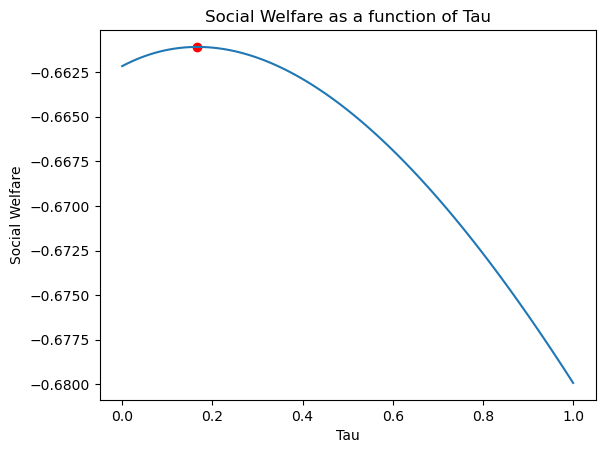

In [13]:
plt.plot(tau2,social_welfare_)
plt.xlabel('Tau')
plt.ylabel('Social Welfare')
plt.title('Social Welfare as a function of Tau')
plt.scatter(optimal_tau,optimal_w,color='red')
plt.show()

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [14]:
par2= SimpleNamespace()
par2.J = 3
par2.N = 10
par2.K = 10000

par2.F = np.arange(1,par2.N+1)
par2.sigma = 2

par2.v = np.array([1,2,3])
par2.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


The expected utility is a matrix N by J because we are averaging over the simulated draws. The realized utility is found by computing all the realized utilities for each career choice, for $K = 10000$. The average realized utility is calculated by averaging the realized utility over i in order to get the average realized utility for $K = 10000$, for each career choice j.

In [15]:
# Initialize the expected utility array
np.random.seed(123)

# Generate epsilon samples
epsilon_samples = np.random.normal(0, par2.sigma, (par2.N, par2.K, par2.J))

def calculate_expected_utility_and_average(par2, epsilon_samples):

        # Initialize the expected utility matrix
        expected_utilities = np.zeros((par2.N, par2.J))

        # Calculate the expected utility for each career track
        for j in range(par2.J):
                expected_utilities[:, j] = par2.v[j] + epsilon_samples[:, :, j].mean(axis=1)

        # Determine the career choice for each graduate
        career_choices = np.argmax(expected_utilities, axis=1)

        # Calculate the realized utility for each graduate based on their career choice
        realized_utilities = np.zeros((par2.N,par2.K))
        for i in range(par2.N):
                chosen_career = career_choices[i]
                realized_utilities[i,:] = par2.v[chosen_career] + epsilon_samples[i, :, chosen_career]

        # Calculate the realized utility that they would have get by choosing each carrer
        all_realized_utilities = np.zeros((par2.N,par2.K,par2.J))
        for i in range(par2.N):
                for j in range(par2.J):
                        all_realized_utilities[i,:,j] = par2.v[j] + epsilon_samples[i, :, j]

        # Calculate the average realized utility for k =10000 for each j
        average_realized_utility= all_realized_utilities.mean(axis=0)
        return expected_utilities, career_choices, average_realized_utility

expected_utilities_0, career_choices_0, average_realized_utility = calculate_expected_utility_and_average(par2, epsilon_samples)

In [16]:
#Tabulating expected utilities
expected_utilities = expected_utilities_0  

column_headers = ["Career 1", "Career 2", "Career 3"]
row_headers = ["Individual 1", "Individual 2", "Individual 3", "Individual 4", "Individual 5", "Individual 6", "Individual 7", "Individual 8", "Individual 9", "Individual 10"]

print(tabulate(expected_utilities, headers=column_headers, showindex=row_headers))

                 Career 1    Career 2    Career 3
-------------  ----------  ----------  ----------
Individual 1     1.03174      2.02205     2.98592
Individual 2     0.978093     2.02388     3.01023
Individual 3     0.96856      2.03313     3.00685
Individual 4     0.991127     1.98175     2.97699
Individual 5     1.01934      2.02559     2.98539
Individual 6     1.01944      2.01026     3.01253
Individual 7     0.978483     2.00321     3.05517
Individual 8     0.983074     2.03094     2.99923
Individual 9     1.02836      1.973       2.97751
Individual 10    1.00053      2.00828     3.00272


In [17]:
print(f'average_realized_utility for k=10000 for each j is {average_realized_utility}')

average_realized_utility for k=10000 for each j is [[0.69740933 1.60161949 2.88276235]
 [1.72106196 2.73586675 2.79532932]
 [0.74868583 2.754803   3.91000797]
 ...
 [1.73110171 1.84390612 3.38474913]
 [0.82319416 1.93264996 2.82032167]
 [0.73950459 2.3589525  4.26891497]]


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

In [18]:
# Set random seed for reproducibility
np.random.seed(123)

# Initialize arrays to store results
chosen_careers = np.zeros((par2.N, par2.K), dtype=int)
prior_expectations = np.zeros((par2.N, par2.K))
realized_utilities = np.zeros((par2.N, par2.K))
all_prior_expected_utilities = np.zeros((par2.N, par2.J, par2.K))  

# Run simulation for K iterations
for k in range(par2.K):

    # Generate epsilon samples for friends - I use max because F is different foreach individual i but we can not have a third dimension different 
    #depending on the indivudal so I use max and do a trick after using :F_i
    epsilon_friends = np.random.normal(0, par2.sigma, (par2.N, par2.J, max(par2.F)))

    # Generate epsilon samples for the graduates
    epsilon_graduates = np.random.normal(0, par2.sigma, (par2.N, par2.J))

    # Calculate the prior expected utility for each career track for each individual
    for i in range(par2.N):
        F_i = par2.F[i]
        prior_expected_utility = np.zeros((par2.J))

        for j in range(par2.J):
                # Calculate the prior expected utility based on friends Notice that I use :F_i because the number of friends is different for each individual
                #Maybe there is a more efficient way to do it, meaning, not drawing number that I will not use but I could not find it
                prior_expected_utility[j] = par2.v[j] + epsilon_friends[i, j,:F_i].mean()
        all_prior_expected_utilities[i, :, k] = prior_expected_utility
        # Choose the career track with the highest prior expected utility
        chosen_career = np.argmax(prior_expected_utility)
        chosen_careers[i, k] = chosen_career
        prior_expectations[i, k] = prior_expected_utility[chosen_career]

        # Calculate the realized utility for the chosen career
        realized_utilities[i, k] = par2.v[ chosen_careers[i, k]] + epsilon_graduates[i,  chosen_careers[i, k]]


In [19]:
print(realized_utilities)
print("-----------------")
print(prior_expectations)

[[ 1.68169738 -1.10479681  2.3515293  ...  2.18322262  2.16798147
   0.28548692]
 [ 5.63321119  1.18682096  0.62614923 ... -0.27255808  0.34686838
   0.10976829]
 [ 3.68527596  3.19184082  1.02044044 ...  2.96963133  2.2341232
   3.92910972]
 ...
 [ 0.24055004  2.19568053  4.21958101 ...  3.90061003  0.50402293
   7.07434286]
 [-0.51080369  3.74304936  0.63068501 ...  2.51327851  4.95796162
   4.19279281]
 [ 3.89827123  3.09400489  2.695211   ...  3.37524978  0.43892838
   1.5921257 ]]
-----------------
[[4.47473715 2.35228043 4.7818335  ... 3.43230948 3.80373753 5.56760862]
 [0.66712647 2.78231923 1.33418158 ... 3.45090273 3.18784449 1.85387026]
 [4.48488059 3.32268072 3.96301283 ... 1.7095142  4.27162654 3.61246517]
 ...
 [2.925487   3.29938376 3.46693268 ... 2.26458665 3.7471759  2.40447435]
 [3.42345547 3.83683507 3.14305096 ... 3.32618122 3.81504804 2.50422383]
 [3.34312815 3.06334357 2.61516379 ... 3.02358152 4.09350593 2.75868906]]


**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In [20]:
# Initialize matrix to store results
share_of_graduates = np.zeros((par2.N, par2.J))
avg_subjective_expected_utility = np.zeros((par2.N, par2.J))
avg_realized_utility = np.zeros((par2.N, par2.J))

for i in range(par2.N):
    for j in range(par2.J):
        # Share of graduates choosing career j
        share_of_graduates[i, j] = np.mean(chosen_careers[i,:] == j)
        
        # Average subjective expected utility for career j
        avg_subjective_expected_utility[i, j] = np.mean(prior_expectations[i,:][chosen_careers[i,:] == j])
        
        # Average realized utility for career j
        avg_realized_utility[i, j] = np.mean(realized_utilities[i,:][chosen_careers[i,:] == j])

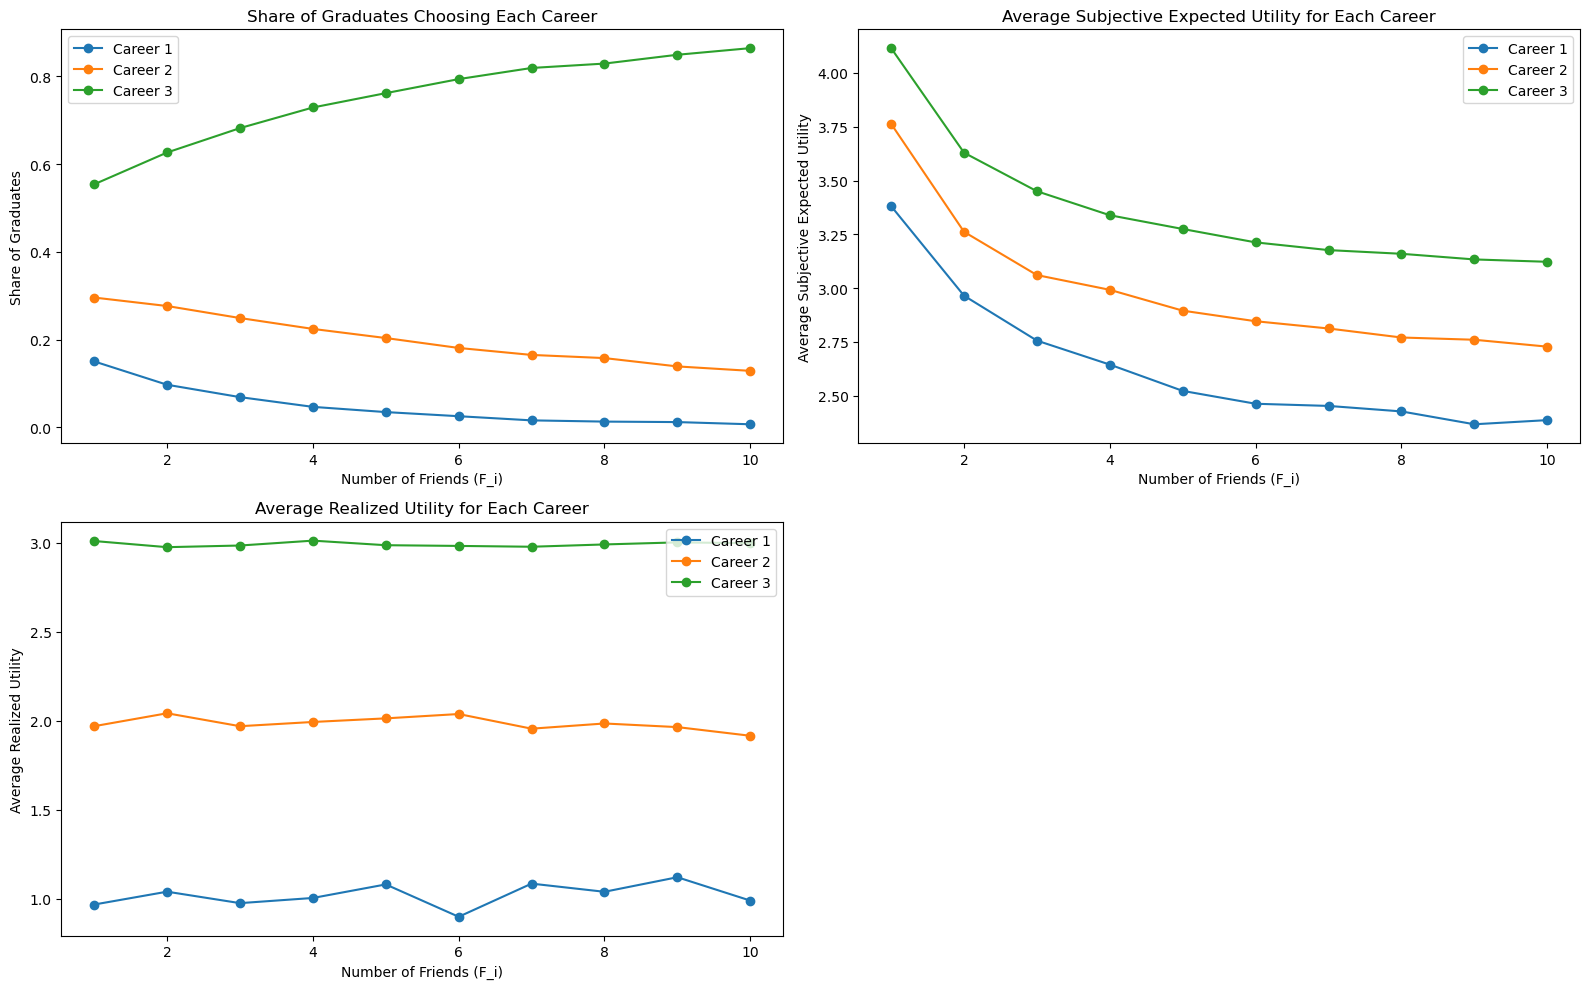

In [21]:
# Plotting the results
plt.figure(figsize=(16, 10))

# Share of graduates choosing each career
plt.subplot(2, 2, 1)
for j in range(par2.J):
    plt.plot(par2.F, share_of_graduates[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Number of Friends (F_i)')
plt.ylabel('Share of Graduates')
plt.title('Share of Graduates Choosing Each Career')
plt.legend()

# Average subjective expected utility
plt.subplot(2, 2, 2)
for j in range(par2.J):
    plt.plot(par2.F, avg_subjective_expected_utility[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Number of Friends (F_i)')
plt.ylabel('Average Subjective Expected Utility')
plt.title('Average Subjective Expected Utility for Each Career')
plt.legend()

# Average realized utility
plt.subplot(2, 2, 3)
for j in range(par2.J):
    plt.plot(par2.F, avg_realized_utility[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Number of Friends (F_i)')
plt.ylabel('Average Realized Utility')
plt.title('Average Realized Utility for Each Career')
plt.legend()

plt.tight_layout()
plt.show()

The first graph (upper left) shows the share of graduates choosing each career, with number of friends on the horizontal axis and share of graduates on the vertical axis. A positive correlation is found to exist between the number of friends and career 3, i.e. the share of graduates choosing career 3 increases with their number of firends. Furthermore, as the number of friends increases, the average of the error term caused by the noise made by friends tends to 0, i.e. its mean is 0. This implies that as the number of friends increases individuals realize that career 3 is the best option.

The second graph (lower left) shows the average realised utility for each career, with number of friends on the horizontal axis and Average realized utility on the vertical axis. Career 1, 2, and 3 average around 3, 2, and 1, respectively. This is not surprising as these utilities match our ex-ante utilities for J=3 when the error term is around 0. This occurs because the average realized utility does not account for the error caused by the friends but only accounts for the error of the individual. Indeed, the fact that each individual is averaged over the number of draws too, leads the average to be close to 0, i.e. the mean in the population to be 0.

The third graph (upper right) shows the average subjective expected utility for each career, with number of friends on the horizontal axis and average subjective expected utility on the vertical axis. For all careers, the average subjective expected utility is negatively correlated with the number of friends. For instance, having only one friend leads an individual i to have a larger error term (noise term) than that i gets when having multiple friends (i.e. averaging over more friends causes the mean of the error to become close to 0). Overall, as the error term is getting closer and closer to 0, all careers are converging towards the average realised utility.

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [22]:
#Initialize matrix to store results
chosen_careers_year2 = np.zeros((par2.N, par2.K), dtype=int)
all_prior_expected_utilities_year2 = np.zeros((par2.N,par2.J, par2.K))
realized_utilities_year2 = np.zeros((par2.N, par2.K))
switched_careers = np.zeros((par2.N, par2.J))  
prior_expectations_2 = np.zeros((par2.N, par2.K))
switched = np.zeros((par2.J,par2.N))
# To track the number of graduates choosing each initial career and their switching behavior
switch_counts = np.zeros(par2.N)

#loop over the draws
for k in range(par2.K):

    #loop over N individuals
    for i in range(par2.N):
        
    # After one year, update priors considering switching cost (year 2)
        for j in range(par2.J):
            if j != chosen_careers[i, k]:
                all_prior_expected_utilities_year2[i,j, k] = all_prior_expected_utilities[i,j, k] - par2.c
            else:
                all_prior_expected_utilities_year2[i,j, k] = realized_utilities[i, k]

        # Choose the career track with the highest prior expected utility
        chosen_career_year2 = np.argmax(all_prior_expected_utilities_year2[i, :, k])
        chosen_careers_year2[i, k] = chosen_career_year2
        #extract the prior expectation for the chosen career
        prior_expectations_2[i, k] = all_prior_expected_utilities_year2[i,chosen_career,k]
        # Calculate the realized utility for the chosen career (year 2)
        if chosen_careers_year2[i,k] != chosen_careers[i, k]:
            realized_utilities_year2[i, k] = realized_utilities[i, k]  - par2.c
            # Count the number of graduates who switched careers conditional on the type
            switch_counts[i] += 1
            # Count the number of graduates who switched careers by type and condition on what they chose in the first year
            if chosen_careers[i,k] ==0:
                switched[0,i] += 1
            elif chosen_careers[i,k] ==1:
                switched[1,i] += 1
            else:
                switched[2,i] += 1
        else:
             realized_utilities_year2[i, k] = realized_utilities[i, k] 

# Calculate the share of graduates who switched careers
share_of_switched = switched / switch_counts
# Calculate the average subjective expected utility and realized utility 
average_subjective_expected_utility = np.mean(prior_expectations_2, axis=1)
# Calculate the average realized utility
average_realized_utility = np.mean(realized_utilities_year2, axis=1)

The "share of switched" represents the share among all that switched career conditional on which career they chose in the first period. The average subjective expected utility is a 10 by 1 as it represents the average expected utility for each chosen career of the utility among the draws. Similarly, the average realized utility is a 10 by 1 matrix containing the average realized utilities for each chosen career.

In [23]:
print(share_of_switched)
print("---------------")
print(average_subjective_expected_utility)
print("---------------")
print(average_realized_utility)

[[0.26829268 0.1889703  0.14727723 0.10416667 0.07759815 0.06596558
  0.03931452 0.032      0.0302409  0.02013423]
 [0.36619718 0.35750096 0.36592409 0.36258865 0.33764434 0.29780115
  0.29737903 0.2815     0.26294208 0.25554982]
 [0.36551013 0.45352873 0.48679868 0.53324468 0.58475751 0.63623327
  0.66330645 0.6865     0.70681702 0.72431595]]
---------------
[1.96177878 2.19373581 2.35499573 2.4972677  2.54711518 2.61339341
 2.65971811 2.69011244 2.74046618 2.76301128]
---------------
[2.10540727 2.2714     2.35227901 2.4655354  2.50694761 2.55077806
 2.58196823 2.60775058 2.64190012 2.6520721 ]


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [24]:
# Use the specified random number generator
rng = np.random.default_rng(2024)

# Generate random points for X and y
X = rng.uniform(size=(50, 2))
y = rng.uniform(size=(2,))
m = np.empty((50))


def compute_ABCD(X,y):
    '''Compute the points A, B, C, and D according to the conditions specified above'''

    # compute A values
    I_A = (X[:,0] > y[0]) & (X[:,1] > y[1])
    X_A = X[I_A]
    if len(X_A) > 0:
        for i, (x1, x2) in enumerate(X_A):
            m[i] = ((x1 - y[0])**2 + (x2 - y[1])**2)**0.5
        A = X_A[np.argmin(m[:len(X_A)])]
    else:
        A = np.array([np.nan, np.nan])

    # compute B values
    I_B = (X[:,0] > y[0]) & (X[:,1] < y[1])
    X_B = X[I_B]
    if len(X_B) > 0:
        for i, (x1, x2) in enumerate(X_B):
            m[i] = ((x1 - y[0])**2 + (x2 - y[1])**2)**0.5
        B = X_B[np.argmin(m[:len(X_B)])]
    else:
        B = np.array([np.nan, np.nan])
    

    # compute C values
    I_C = (X[:,0] < y[0]) & (X[:,1] < y[1])
    X_C = X[I_C]
    if len(X_C) > 0:
        for i, (x1, x2) in enumerate(X_C):
            m[i] = ((x1 - y[0])**2 + (x2 - y[1])**2)**0.5
        C = X_C[np.argmin(m[:len(X_C)])]
    else:
        C = np.array([np.nan, np.nan])


    # compute D values
    I_D = (X[:,0] < y[0]) & (X[:,1] > y[1])
    X_D = X[I_D]
    if len(X_D) > 0:
        for i, (x1, x2) in enumerate(X_D):
            m[i] = ((x1 - y[0])**2 + (x2 - y[1])**2)**0.5
        D = X_D[np.argmin(m[:len(X_D)])]
    else:
        D = np.array([np.nan, np.nan])
    return A, B, C, D

A, B, C, D  = compute_ABCD(X,y)

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

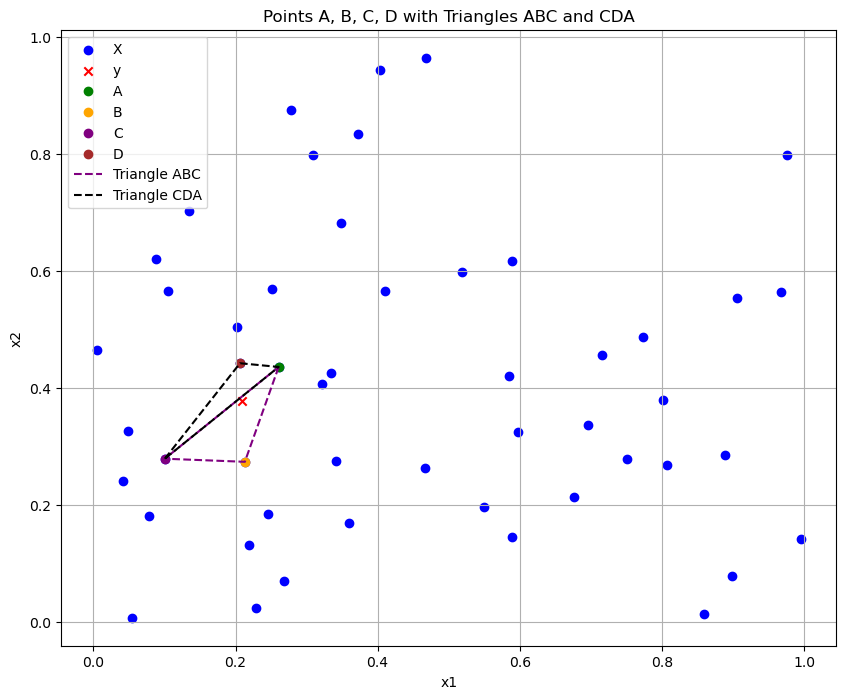

In [25]:
# Plot the points and the triangles
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], label='X', color='blue')
plt.scatter(y[0], y[1], label='y', color='red', marker='x')
plt.scatter(A[0], A[1], label='A', color='green')
plt.scatter(B[0], B[1], label='B', color='orange')
plt.scatter(C[0], C[1], label='C', color='purple')
plt.scatter(D[0], D[1], label='D', color='brown')

# Plot triangles ABC and CDA
if not (np.isnan(A).any() or np.isnan(B).any() or np.isnan(C).any()):
    plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], color='purple', linestyle='--', label='Triangle ABC')

if not (np.isnan(C).any() or np.isnan(D).any() or np.isnan(A).any()):
    plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], color='black', linestyle='--', label='Triangle CDA')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Points A, B, C, D with Triangles ABC and CDA')
plt.grid(True)
plt.show()


The graph above illustrates A, B, C, D, X, y, and the triangles ABD and CDA. The blue dots, X, are all the random point in the unit square with a uniform distribution between 0 and 1. As illustrated, the point y is inside the triangle ABC.

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [26]:
def barycentric_coordinates(A, B, C, y):
    """Compute the barycentric coordinates of point y with respect to triangle ABC."""
    denominator = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denominator
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denominator
    r3 = 1 - r1 - r2
    return r1, r2, r3

r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
print(f'Barycentric coordinates of point y with respect to triangle ABC: r1 = {r1_ABC}, r2 = {r2_ABC}, r3 = {r3_ABC}')

r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
print(f'Barycentric coordinates of point y with respect to triangle CDA: r1 = {r1_CDA}, r2 = {r2_CDA}, r3 = {r3_CDA}')

#Since the barycentric coordinates are positive only if the point is inside the triangle, we can use this to check if the point is inside the triangle
def is_inside_triangle(r1, r2, r3):
    """Check if the point is inside the triangle."""
    return (r1 >= 0) & (r2 >= 0) & (r3 >= 0)

is_inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)
is_inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)
print(f'Is point y inside triangle ABC? {is_inside_ABC}')
print(f'Is point y inside triangle CDA? {is_inside_CDA}')

Barycentric coordinates of point y with respect to triangle ABC: r1 = 0.6286263152916166, r2 = 0.06910145494351515, r3 = 0.3022722297648682
Barycentric coordinates of point y with respect to triangle CDA: r1 = 0.3682598757102867, r2 = -0.13392661883334067, r3 = 0.765666743123054
Is point y inside triangle ABC? True
Is point y inside triangle CDA? False


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [27]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [28]:

def approximation(y, X,f):
    A, B, C, D = compute_ABCD(X,y)
    r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
    r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
    if is_inside_triangle(r1_ABC, r2_ABC, r3_ABC):
        return r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
    elif is_inside_triangle(r1_CDA, r2_CDA, r3_CDA):
        return r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
    else:
        return np.nan
# Compute the approximation of the function f at point y
approximation_y = approximation(y, X, f)


In [29]:
print(f'Approximation of the function f at point y: {approximation_y}')
print(f'True value of the function f at point y: {f(y)}')

Approximation of the function f at point y: 0.08405201731052576
True value of the function f at point y: 0.0789565216259594


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [30]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

# Compute the approximations of the function f at the points in Y
approximations_Y = [approximation(y, X, f) for y in Y]
print(f'Approximations of the function f at points in Y: {approximations_Y}')
print(f'True values of the function f at points in Y: {[f(y) for y in Y]}')

Approximations of the function f at points in Y: [0.04032631372248057, 0.15874233999349835, nan, 0.15874233999349835, 0.2512901561119622]
True values of the function f at points in Y: [0.04000000000000001, 0.16000000000000003, 0.6400000000000001, 0.16000000000000003, 0.25]


The aproximation for $y = (0.8,0.8)$ can not be done because there no exist $x$'s such that $x_1 > 0.8$ and $x_2 > 0.8$